# Loading Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set(style="white")

In [57]:
df = pd.read_csv("nyc_taxi_trip_duration.csv")

In [58]:
df.shape

(729322, 11)

In [59]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.95,40.78,-73.96,40.77,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.99,40.73,-73.99,40.69,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-74.00,40.72,-73.95,40.77,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.96,40.76,-73.96,40.78,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.02,40.71,-73.99,40.74,N,848


We have 11 columns with 729322 row of data.

Based on the data, we have a mix of numerical and categorical variables (store_and_fwd_flag and vendor_id are categorical).

In [60]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [61]:
pd.options.display.float_format = '{:.2f}'.format

In [62]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.00,729322.00,729322.00,729322.00,729322.00,729322.00,729322.00
mean,1.54,1.66,-73.97,40.75,-73.97,40.75,952.23
std,0.50,1.31,0.07,0.03,0.07,0.04,3864.63
min,1.00,0.00,-121.93,34.71,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,663.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-65.90,51.88,-65.90,43.92,1939736.00


From the describe, we see that there are no missing values.

vendor_id is not numeric column though its represented as numeric.

The average trip duration takes about 952.23 seconds/26 mins with max of 1939736 seconds and minimum of 1 second. Obivisouly, this needs to be treated as there are outliers.

# Target Variable

We are trying to predict the trip_duration and this is linear regression problem.

In [63]:
df['trip_duration'].groupby(pd.cut(df['trip_duration'], np.arange(1, 7800, 600))).count()

trip_duration
(1, 601]        326787
(601, 1201]     255084
(1201, 1801]     91086
(1801, 2401]     31745
(2401, 3001]     12825
(3001, 3601]      5726
(3601, 4201]      2625
(4201, 4801]      1353
(4801, 5401]       591
(5401, 6001]       252
(6001, 6601]        99
(6601, 7201]        44
Name: trip_duration, dtype: int64

From the above, we can see that the majority of the trips happened within an hour

In [64]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

# Calculate Day of Week

In [66]:
from datetime import date
from datetime import datetime
import datetime as dt
import calendar

In [67]:
# infer Day of Week using the start date
df['day_of_week'] = df['pickup_datetime'].apply(lambda x: calendar.day_name[datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday()])

df['day_of_week_num'] = df['pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday())

In [68]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,day_of_week_num
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.95,40.78,-73.96,40.77,N,400,Monday,0
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.99,40.73,-73.99,40.69,N,1100,Friday,4
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-74.00,40.72,-73.95,40.77,N,1635,Sunday,6
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.96,40.76,-73.96,40.78,N,1141,Tuesday,1
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.02,40.71,-73.99,40.74,N,848,Wednesday,2


## Calculate the Distance using Latitude and Longtitude

In [69]:
from geopy.distance import geodesic

def calc_dist(row):
    return geodesic((row.pickup_latitude, row.pickup_longitude),
                                   (row.dropoff_latitude, row.dropoff_longitude)).km

In [70]:
df['dist_in_kms'] = df.apply(calc_dist, axis=1)

In [71]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,day_of_week_num,dist_in_kms
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.95,40.78,-73.96,40.77,N,400,Monday,0,1.20
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.99,40.73,-73.99,40.69,N,1100,Friday,4,4.12
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-74.00,40.72,-73.95,40.77,N,1635,Sunday,6,7.25
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.96,40.76,-73.96,40.78,N,1141,Tuesday,1,2.36
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.02,40.71,-73.99,40.74,N,848,Wednesday,2,4.33


# Univariate Analysis

## Numerical Variables

In [72]:
num_cols = ['passenger_count', 'trip_duration', 'dist_in_kms']

### Passenger Count

In [73]:
df['passenger_count'].value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
9         1
7         1
Name: passenger_count, dtype: int64

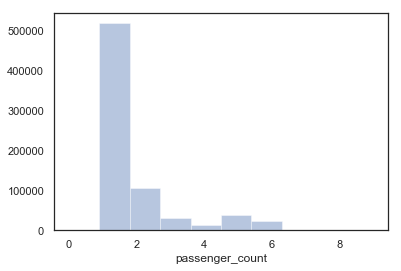

In [74]:
sns.distplot(df['passenger_count'], kde = False, bins=10)

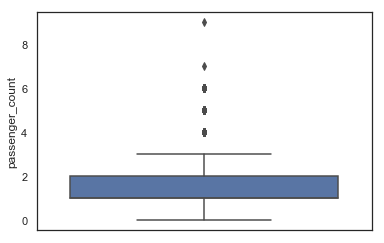

In [75]:
sns.boxplot(df['passenger_count'], orient='vertical')

From the plot, its clear the there were more trips with 1 or 2 passengers. Anything, more than 2 are considered as outliers. There are trips with "0" passengers which should also be treaded as an outlier.

### Trip Duration

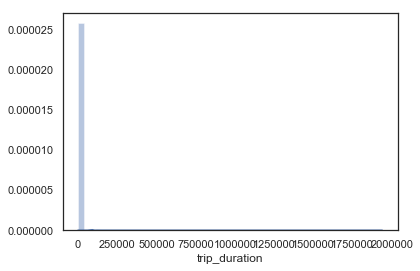

In [76]:
sns.distplot(df['trip_duration'])

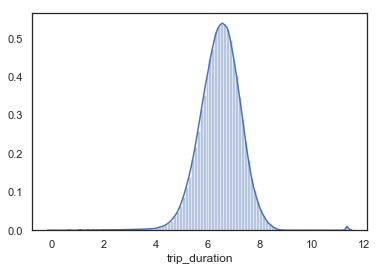

In [77]:
temp = df[df['trip_duration'] != df['trip_duration'].max()]['trip_duration']
temp = np.log(temp) # applying log transfromation
sns.distplot(temp, bins=100)

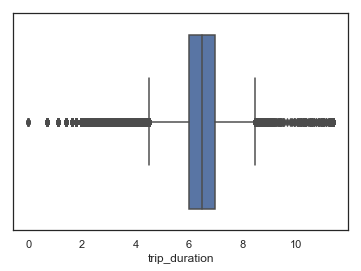

In [78]:
sns.boxplot(temp)

From the above plots, we see that there are trips with duration as 0 and these are outliers.

Let's plot the trip_duration that's greater than minute and log transformation applied.

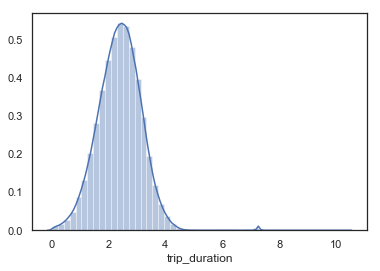

In [79]:
temp1 = np.log(df['trip_duration']/60) # convert trip duration to minutes
sns.distplot(temp1[temp1 > 0], bins=50)

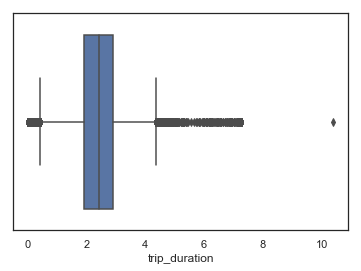

In [80]:
sns.boxplot(temp1[temp1 > 0])

The trip duration with log transformation and greater than a minute. Looking at the box plot, we can see there are outliers.

### Distance in Kms

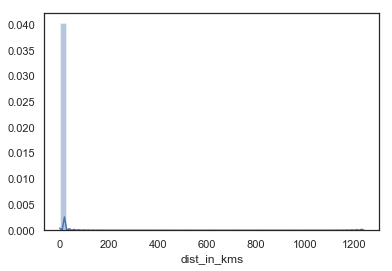

In [81]:
sns.distplot(df['dist_in_kms'])

In [82]:
df['dist_in_kms'].describe()

count   729322.00
mean         3.44
std          4.36
min          0.00
25%          1.23
50%          2.10
75%          3.88
max       1240.51
Name: dist_in_kms, dtype: float64

There are trips with distance in metres as 0 and these are outliers.

In [83]:
temp = np.log(df['dist_in_kms'] +  3.44) # adding the mean distance to variable before applying log transformation

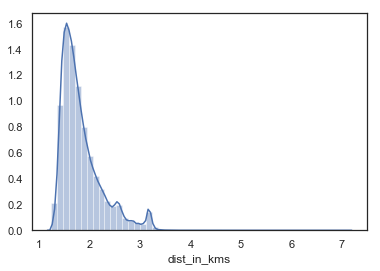

In [84]:
sns.distplot(temp, bins=50)

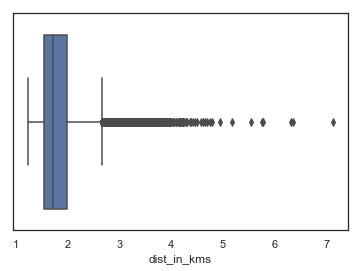

In [85]:
sns.boxplot(temp)

From the histogram above, trip duration is rightly skewed which means there are outliers.

## Trips Taken by Time Range

In [86]:
def time_range(inp):
    if inp >= dt.time(5,0,0)and inp < dt.time(7,0,0):
        return 'Early Morning'
    elif inp >= dt.time(7,0,0)and inp < dt.time(11,0,0):
        return 'Morning'
    elif inp >= dt.time(11,0,0)and inp < dt.time(16,0,0):
        return 'Afternoon'
    elif inp >= dt.time(16,0,0)and inp < dt.time(20,0,0):
        return 'Evening'
    elif inp >= dt.time(20,0,0)and inp < dt.time(23,0,0):
        return 'Night'
    else:
        return 'Late Night'

Lets group the pickup time by hour and check the distribution for various time ranges for the day.

In [87]:
df['pickup_time_range'] = df['pickup_datetime'].apply(lambda x: time_range(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').time()))
df['pickup_time_range'].head()

0          Evening
1       Late Night
2          Evening
3          Morning
4    Early Morning
Name: pickup_time_range, dtype: object

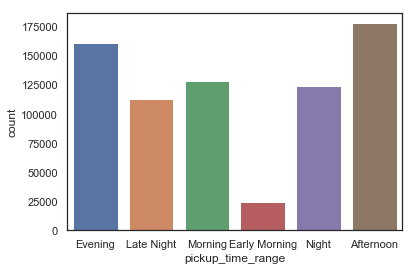

In [88]:
sns.countplot(x='pickup_time_range', data=df)

From the plot, we can conclude that most trips started in the afternoon (between 11AM to 4PM) and least number of trips in the Early Morning (between 5AM to 7AM)

Lets look at the trip count by hour

In [89]:
df['pickup_by_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour

[(0, 24)]

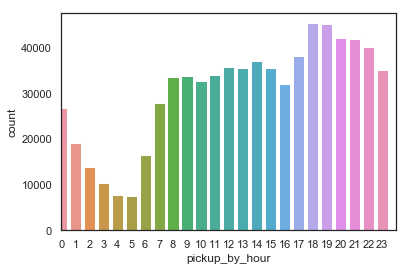

In [90]:
ax = sns.countplot(df['pickup_by_hour'])
ax.set(xlim=(0,24))

From the plot, 6PM & 7PM has more no. of trips and 4AM in the morning with least no. of trips.

## Categorical Variables

We are interested only in the vendor_id, day_of_week and store_and_fwd_flag

In [91]:
cat_cols = ['vendor_id', 'day_of_week', 'store_and_fwd_flag']

In [92]:
for i in range(0,len(cat_cols)):
    print(str(cat_cols[i]) + " - Number of Unique Values: " + str(df[cat_cols[i]].nunique()))

vendor_id - Number of Unique Values: 2
day_of_week - Number of Unique Values: 7
store_and_fwd_flag - Number of Unique Values: 2


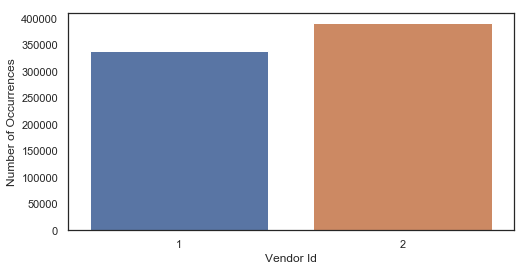

In [93]:
int_level = df['vendor_id'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(int_level.index, int_level.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Vendor Id', fontsize=12)
plt.show()

It is clear from above bar graph that Vendor 2 ran more trips than Vendor 1, however, they are not much different.

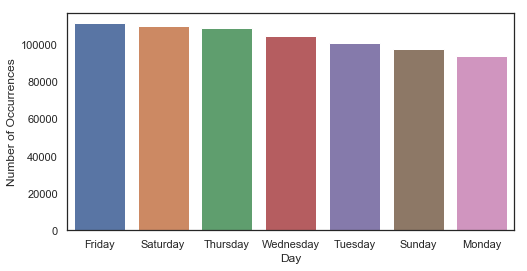

In [94]:
int_level = df['day_of_week'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(int_level.index, int_level.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.show()

We can infer that there were more trips during Friday and Saturdays with Monday having least trips

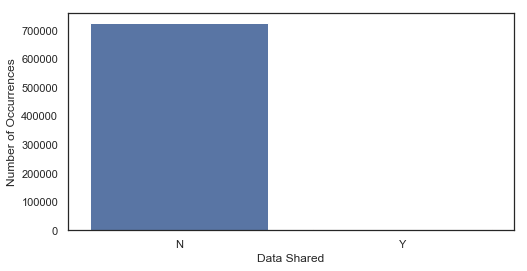

In [95]:
int_level = df['store_and_fwd_flag'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(int_level.index, int_level.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Data Shared', fontsize=12)
plt.show()

In [96]:
print(int_level/len(df['store_and_fwd_flag'])*100)

N   99.45
Y    0.55
Name: store_and_fwd_flag, dtype: float64


Nearly 99.45% trip data are upto date with 0.55% trip details has been stored to be forwarded.

# Bivariate Analysis

## Trip duration and Vendor Id

In [97]:
# removed the outlier, thats the max value as the plot was not meaningful
#f['trip_duration'] = df[df['trip_duration'] != df['trip_duration'].max()]['trip_duration']

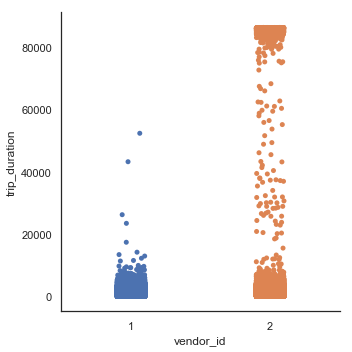

In [98]:
# removed the outlier, thats the max value as the plot was not meaningful
sns.catplot(x='vendor_id', y='trip_duration', data=df[df['trip_duration'] != df['trip_duration'].max()], kind='strip')

From the above, vendor_1 deals mostly with short trips and vendor_2 deals with both short and long trips

## Trip Duration and Day of the Week

In [99]:
days_in_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday', 'Sunday']

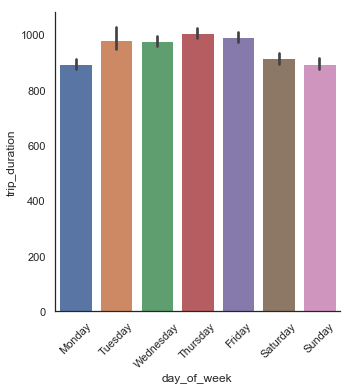

In [100]:
ax = sns.catplot(x='day_of_week', y='trip_duration', kind='bar', data=df, order=days_in_week)
ax.set_xticklabels(rotation=45)

From the above plot, trips on Thursdays takes more time and trips on Sunday, Saturday and Monday takes less time (almost same).

## Trip Duration and Distance

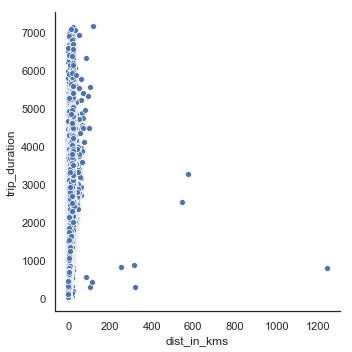

In [102]:
sns.relplot(x="dist_in_kms", y="trip_duration", data=df[df['trip_duration'] <= 7200])

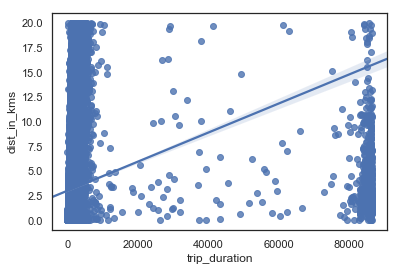

In [124]:
sns.regplot(x="trip_duration",y="dist_in_kms", data=df[(df['trip_duration'] != df['trip_duration'].max()) & (df['dist_in_kms'] <= 20)])

From the above plot, the distance and duration does not have a linear relation. As can be seen, the shorter trips has longer duration. These are clearly data errors that needs to be treated.

## Passenger Count and Vendor Id

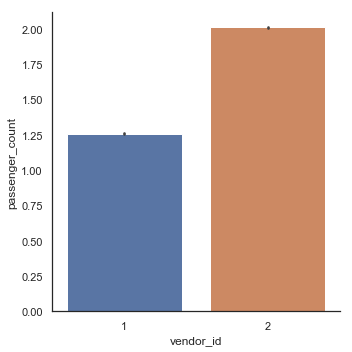

In [130]:
sns.catplot(x="vendor_id",y="passenger_count", data=df, kind="bar")

Vendor 2 was preferred more by trips with 2 passengers and Vendor 1 for trips with 1 passenger.

Lets further analyse passenger preference for vendors using the below plot.

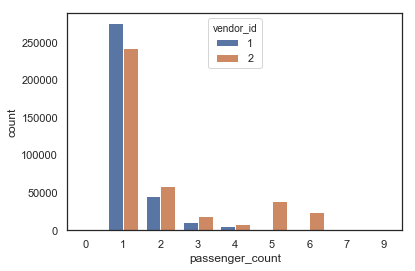

In [135]:
sns.countplot(x='passenger_count', data=df, hue='vendor_id')

From the above plot we can see single passenger prefers Vendor_1 and  Vendor_2 serves 2 or more passengers. 

Also, another finding is that Vendor_2 operates bigger cars to accomodate more passengers.

### Passenger Count and Vendor Id by Day

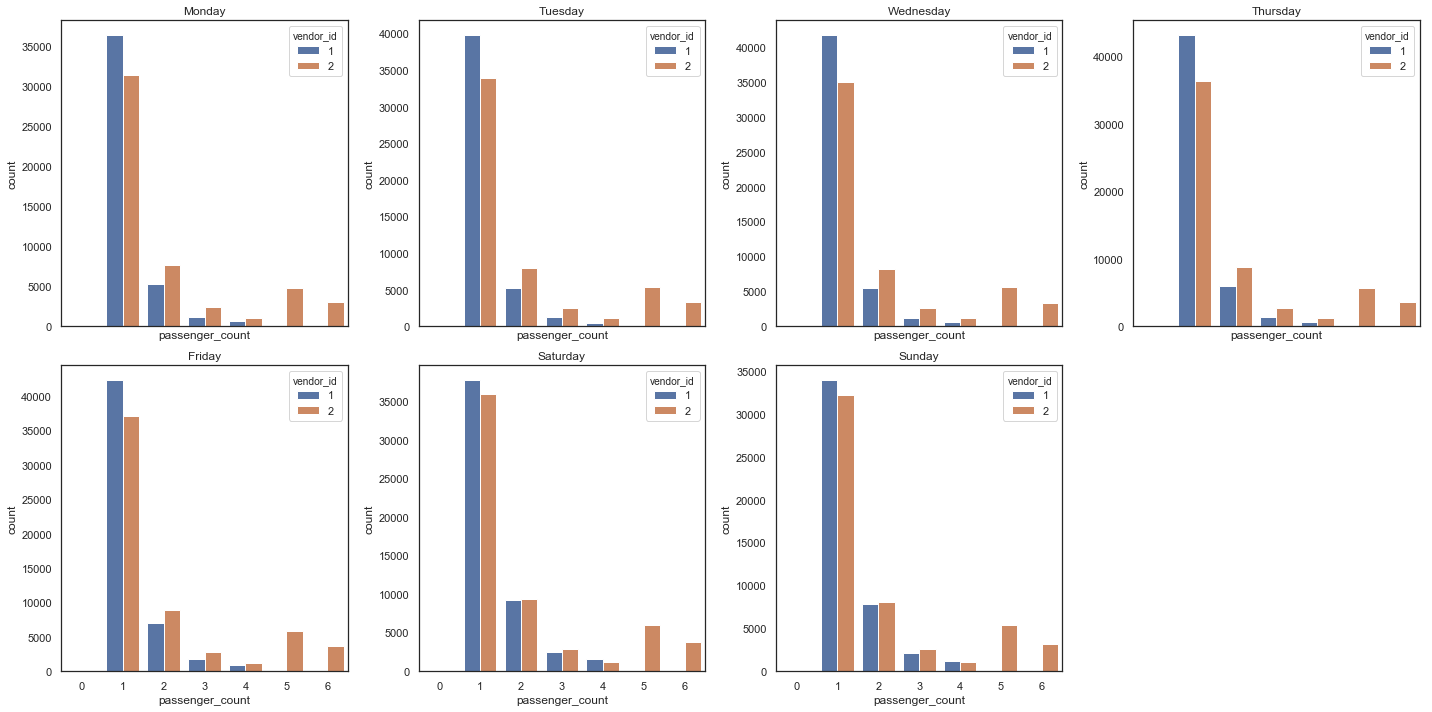

In [174]:
fig,ax = plt.subplots(2, 4, figsize=(20, 10), sharex=True)

r = 0; c= 0;
for dy in days_in_week:
    ax[r][c].set_title(dy)
    sns.countplot(x='passenger_count', data=df[df['day_of_week'] == dy], hue='vendor_id', ax=ax[r][c])    
    c += 1
    if (c > 3) :
        r += 1
        c = 0
plt.tight_layout()
fig.delaxes(ax[r][c])

The trend shows that both vendor 1 and 2 were almost equally preferred during weekends for trips with 2-4 passengers. For 1 passenger trips, vendor 1 was sligthly ahead of vendor 2.

From the plots we can confirm that vendor 2 was preferred for trips with more passengers as they likely operates bigger cars to accomodate more passengers.

## Passenger Count and Duration

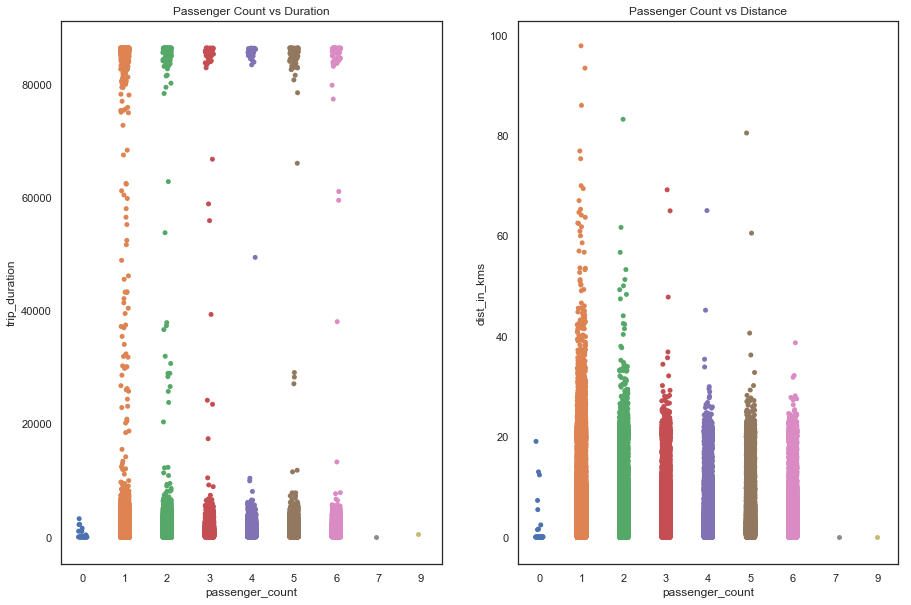

In [252]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.set_title("Passenger Count vs Duration")
sns.catplot(x="passenger_count",y="trip_duration", data=df[df["trip_duration"] != df["trip_duration"].max()], kind="strip", ax=ax1)

ax2.set_title("Passenger Count vs Distance")
sns.catplot(x="passenger_count",y="dist_in_kms", data=df[df["dist_in_kms"] <= 100], kind="strip", ax=ax2)

plt.tight_layout()

plt.close(2)
plt.close(3)

From the above two plots, there is no linear relationship between passenger count and trip duration.

1 passenger took both short and long trips since it can seen that the trip duration is evenly distributed. Whereas 2 or more passengers took trips that were of less distance.

Trips for 2 or more passengers either took trips that took less or more time but not evenly distributed.

Considering both the plots, it can be concluded that 2 or more passengers frequently took shorter trips and travelled shorter distance. The higher duration trips might be a result of data error and needs to be treated.

## Flag and Duration

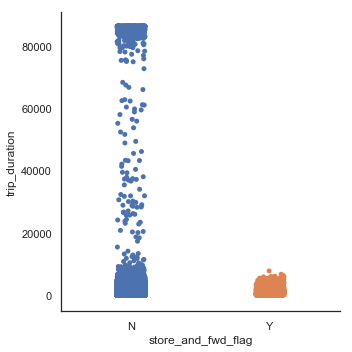

In [192]:
sns.catplot(x="store_and_fwd_flag",y="trip_duration", data=df[df["trip_duration"] != df["trip_duration"].max()])

It can be concluded that the store and forward flag was set only for shorter trips which could be due to connectivity issues.

## Hours and Duration

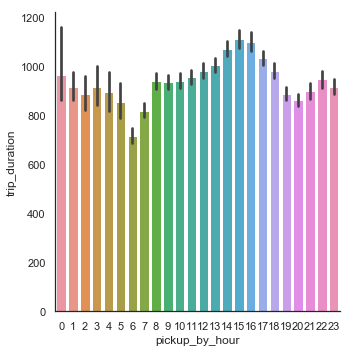

In [194]:
sns.catplot(x="pickup_by_hour", y="trip_duration",kind="bar",data=df)

The longest trips are the trips started between 14-16 hours with trips started between 6-7 hours took less time.

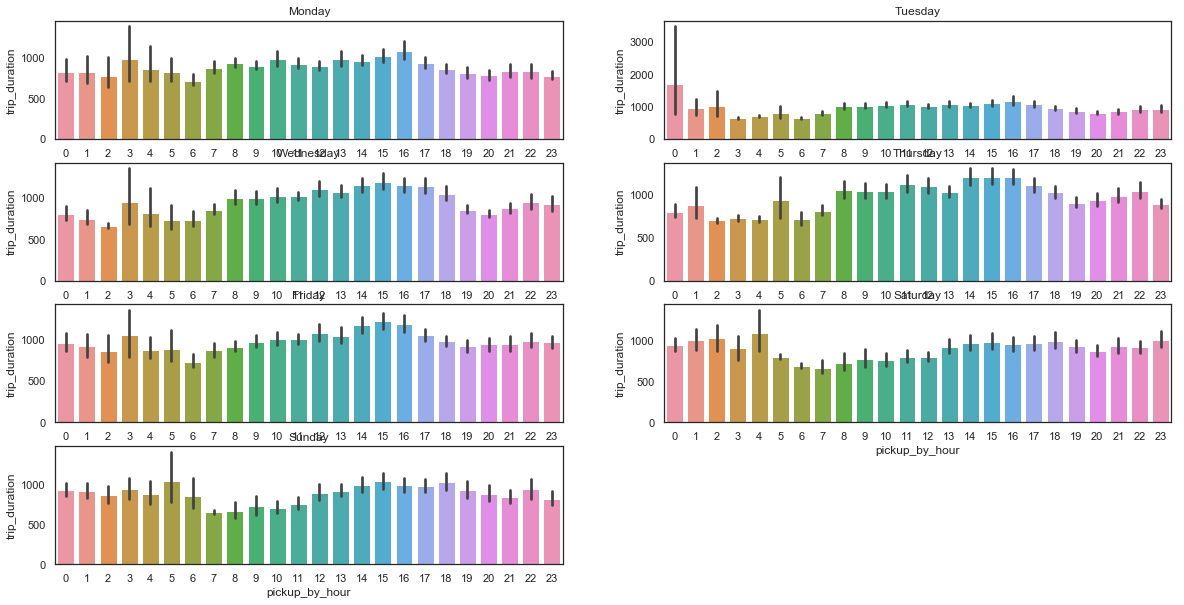

In [246]:
fig,ax = plt.subplots(4, 2, figsize=(20, 10))

r = 0; c= 0;
for dy in days_in_week:
    ax[r][c].set_title(dy)
    sns.catplot(x='pickup_by_hour', y='trip_duration', data=df[df['day_of_week'] == dy], ax=ax[r][c], kind='bar')
    c += 1
    if (c > 1) :
        r += 1
        c = 0
    #print('col:' + str(c))
    #print('row:' + str(r))
plt.tight_layout()
fig.delaxes(ax[r][c])
for i in range(2, 9):
    plt.close(i)
    

# Not sure, if there is a better way to plot. Since I believe catplot uses figure and we are trying to associate
# it with ax and thats why extra plots were generated, which we needed to close.

From the above plots, it can concluded that longer trips were taken on Thursday, Friday and Sataryday and Tuesday has trips with less duration.

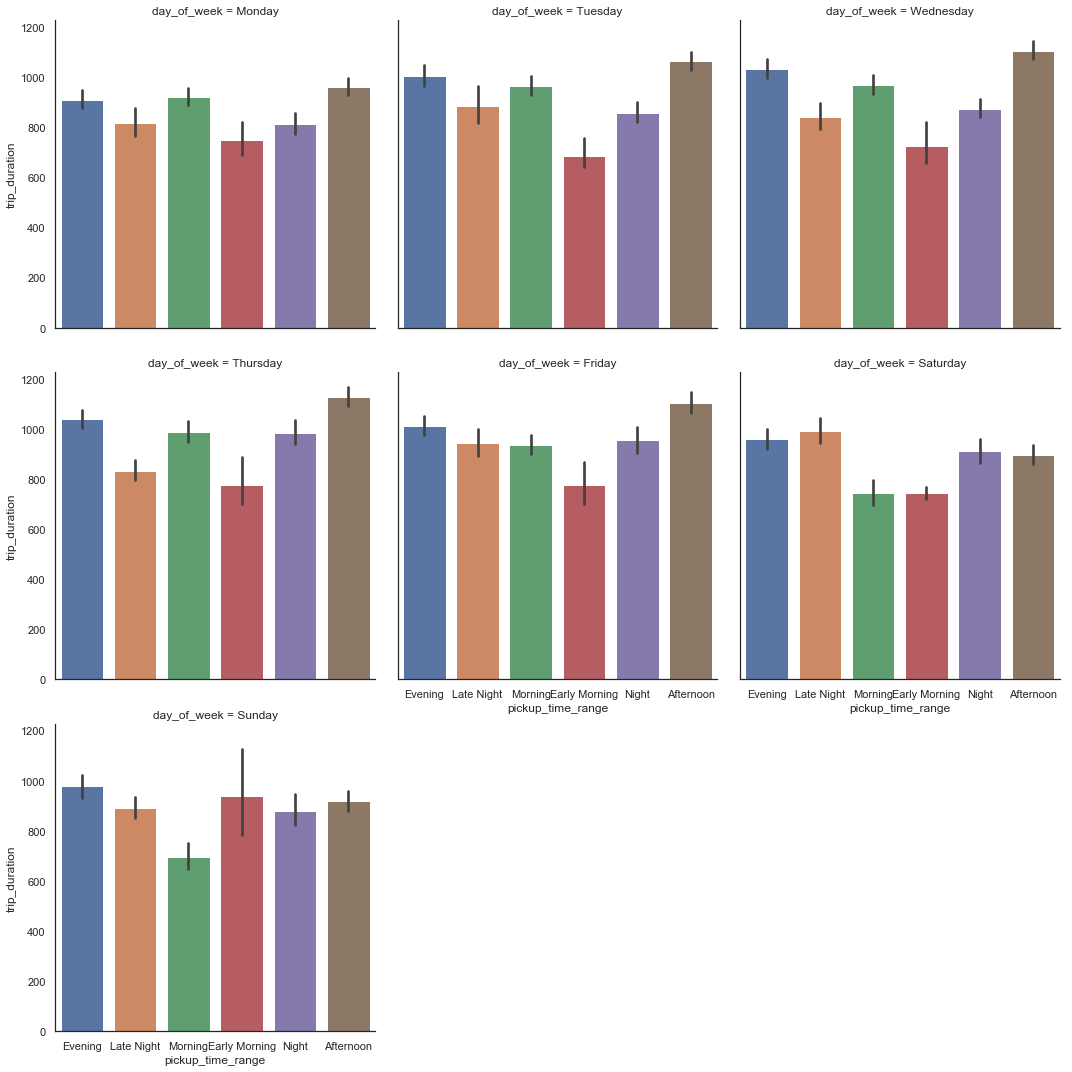

In [272]:
ax = sns.catplot(x='pickup_time_range', y='trip_duration', data=df[df['trip_duration'] != df['trip_duration'].max()],
                 kind='bar', col='day_of_week', col_wrap=3, col_order=days_in_week)

From the above plots, more longer trips were taken on Thursday afternoon.

## Heatmap

In [245]:
df_heatmap = df

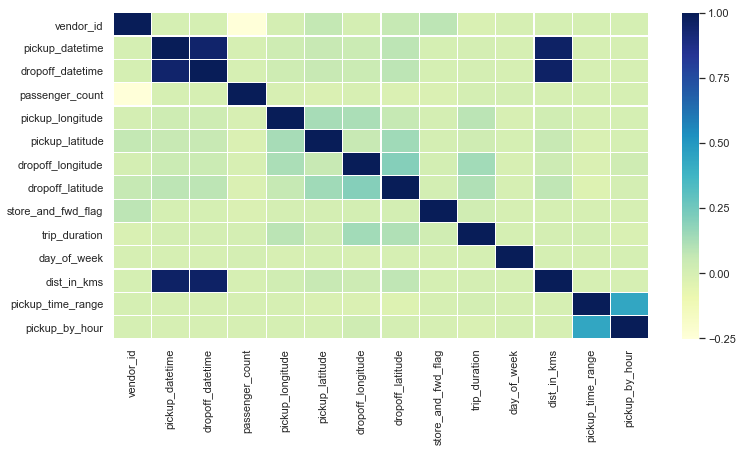

In [244]:
plt.figure(figsize=(12, 6))
df_heatmap.drop(['id', 'day_of_week_num'], axis=1, inplace=True)
corr = df_heatmap.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

# Conclusion

 - Trips on Thursdays took more time. Wheras, trips on Sunday, Saturday and Monday took less time
 - More no. of trips were taken during Friday and Saturday, with Monday having least trips
 - Trips taken between 14-17 hours took more time and trips started at 6 took less time
 - Vendor 2 was preffered for trips with more passengers and provides both longer and shorter trips
 - Vendor 1 was preffered for shorter trips
 - Trip duration varies from few seconds to nearly a day
 - Longer trips were taken on Thursday, Friday and Sataryday and lesser duration trips on Tuesday.

## Next Steps
 - Variable treatment and transformation
 - Feature engineering
 
## Note:
 - Could try to plot pickup and drop off location to identify the location with most trips
 - Pickup and dropoff longitute, latitude were left out from the analysis since the distance was used in the analysis. Also, the pickup hour and pikup days were used in bivariate analysis and i believe, for this excercise, it would not make much of a difference to consider the dropof datetime (or day and hour from it), hence the pickup and drop datetime werent analysed.